<a href="https://colab.research.google.com/github/bavya-sri/Rasmalai/blob/Final/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import os
import keras
import datetime

In [3]:

def PSNR(gt, image, max_value=1):
    """"Function to calculate peak signal-to-noise ratio (PSNR) between two images."""
    height, width , channels= gt.shape
    # gt=cv2.resize(gt, (width//40*40,height//40*40), interpolation=cv2.INTER_CUBIC)
    # print(gt.shape, image.shape)
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [4]:
def get_patches(image):
    '''This functions creates and return patches of given image with a specified patch_size'''
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    height, width , channels= image.shape
    crop_sizes=[1]
    patch_size=40
    patches = []
    for crop_size in crop_sizes: #We will crop the image to different sizes
        crop_h, crop_w = int(height*crop_size),int(width*crop_size)
        image_scaled = cv2.resize(image, (crop_w,crop_h), interpolation=cv2.INTER_CUBIC)
        for i in range(0, crop_h-patch_size+1, int(patch_size/1)):
            for j in range(0, crop_w-patch_size+1, int(patch_size/1)):
              x = image_scaled[i:i+patch_size, j:j+patch_size] # This gets the patch from the original image with size patch_size x patch_size
              patches.append(x)
    return patches

def create_image_from_patches(patches,image_shape):
  '''This function takes the patches of images and reconstructs the image'''
  image=np.zeros(image_shape) # Create a image with all zeros with desired image shape
  patch_size=patches.shape[1]
  p=0
  for i in range(0,image.shape[0]-patch_size+1,int(patch_size/1)):
    for j in range(0,image.shape[1]-patch_size+1,int(patch_size/1)):
      image[i:i+patch_size,j:j+patch_size]=patches[p] # Assigning values of pixels from patches to image
      p+=1
  return np.array(image)
  
def get_image(gt,noise_level):
  '''This function takes a image and adds noise with specified level and return  noisy image and its patches'''
  patches=get_patches(gt)
  height, width , channels= gt.shape
  test_image=cv2.resize(gt, (width//40*40,height//40*40), interpolation=cv2.INTER_CUBIC)
  patches=np.array(patches)
  ground_truth=create_image_from_patches(patches,test_image.shape)

  #predicting the output on the patches of test image
  patches = patches.astype('float32') / 255.
  patches_noisy = patches+ tf.random.normal(shape=patches.shape,mean=0,stddev=noise_level/255) 
  patches_noisy = tf.clip_by_value(patches_noisy, clip_value_min=0., clip_value_max=1.)
  noisy_image=create_image_from_patches(patches_noisy,test_image.shape)
  
  return ground_truth/255.,noisy_image,patches_noisy

In [5]:

test_load = os.listdir("/content/drive/MyDrive/DataScience/test")
train_load = os.listdir("/content/drive/MyDrive/DataScience/train")

x_test =[]
x_train = []

for image in test_load:
  # img = cv2.imread("/content/test/"+image, cv2.IMREAD_GRAYSCALE)
  img = cv2.imread("/content/drive/MyDrive/DataScience/test/"+image)
  if img is not None:
    img = cv2.resize(img, [300,300], interpolation = cv2.INTER_AREA)
    x_test.append(img)

for image in train_load:
  # img = cv2.imread("/content/train/"+image, cv2.IMREAD_GRAYSCALE)
  img = cv2.imread("/content/drive/MyDrive/DataScience/train/"+image)

  if img is not None:
    img = cv2.resize(img, [300,300], interpolation = cv2.INTER_AREA)
    x_train.append(img)

In [6]:
x_test = np.array(x_test)
x_train = np.array(x_train)
print(x_test.shape, x_train.shape)

(200, 300, 300, 3) (400, 300, 300, 3)


In [7]:

noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

print(np.min(x_train_noisy), np.max(x_train_noisy))

print(x_train_noisy.shape, x_train_noisy.shape)


-2.975266911233749 258.5270937930103
(400, 300, 300, 3) (400, 300, 300, 3)


In [8]:
noisy_data = []
train_data = []
for img in x_train:
  gt, noisy, patches_noisy = get_image(img, 50)
  noisy_data.append(noisy)
  train_data.append(gt)

In [9]:
noisy_data = np.array(noisy_data)
train_data = np.array(train_data)

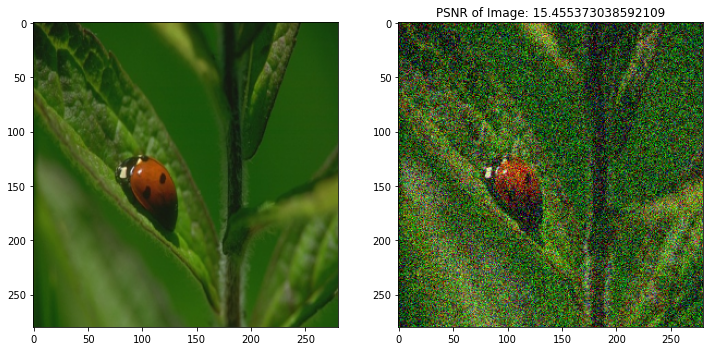

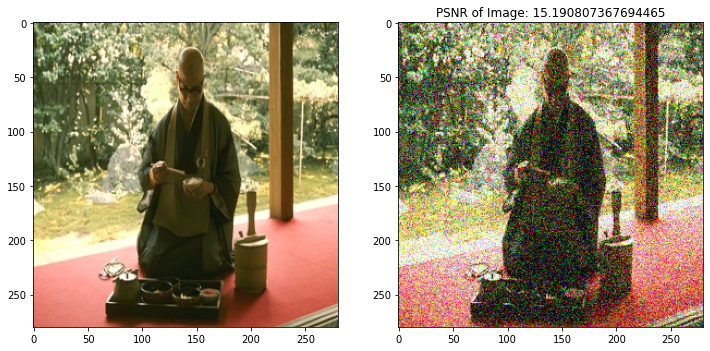

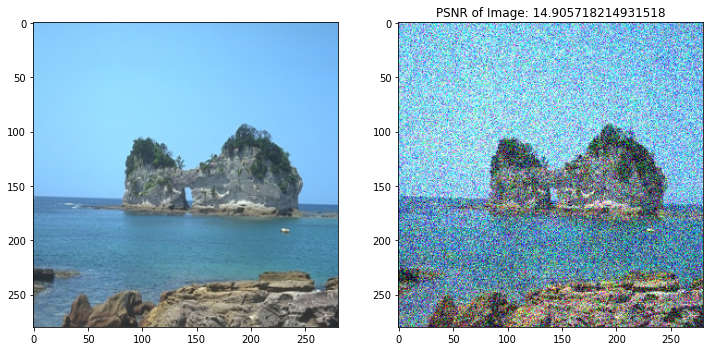

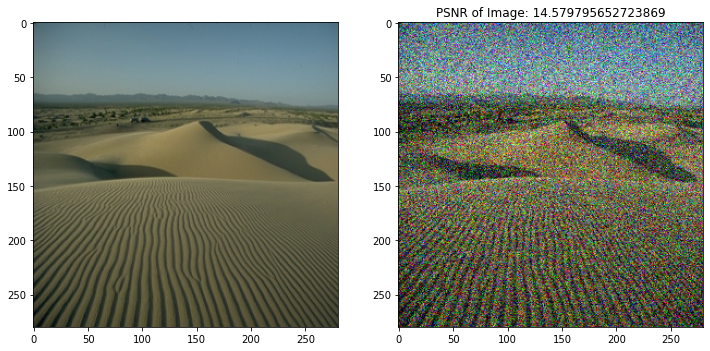

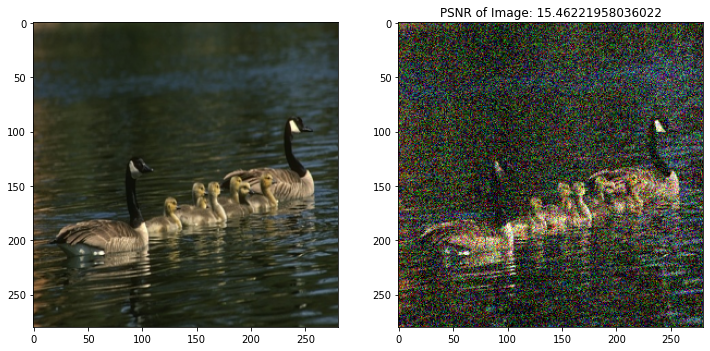

In [10]:
idxs = np.random.randint(0, 200, 5)
for img in zip(train_data[idxs], noisy_data[idxs]):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
  plt.title(f'PSNR of Image: {PSNR(img[0],img[1])}')
  ax1.imshow(img[0])
  ax2.imshow(img[1])
  plt.show()

In [11]:

def create_model():
  x = keras.Input(shape=(280, 280, 3))
# Encoder
  e_conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  pool1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(e_conv1)
  batchnorm_1 = tf.keras.layers.BatchNormalization()(pool1)
  e_conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
  pool2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(e_conv2)
  batchnorm_2 = tf.keras.layers.BatchNormalization()(pool2)
  e_conv3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
  h = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(e_conv3)
# Decoder
  d_conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(h)
  up1 = tf.keras.layers.UpSampling2D((2, 2))(d_conv1)
  d_conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
  up2 = tf.keras.layers.UpSampling2D((2, 2))(d_conv2)
  d_conv3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
  up3 = tf.keras.layers.UpSampling2D((2, 2))(d_conv3)
  r = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
  model = keras.Model(x, r)
  model.compile(optimizer='adam', loss='mse')
  return model

In [12]:
auto_encoder = create_model()
auto_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 280, 280, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 280, 280, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 140, 140, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 140, 140, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 140, 140, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 70, 70, 32)       0     

In [13]:
def scheduler(epoch,lr):
  return lr*0.95

checkpoint_path = "/content/drive/MyDrive/DataScience/autoencoder.h5" 
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=0,save_best_only=False) 

# Tensorbaord 
logdir = os.path.join("/content/drive/MyDrive/DataScience/logs_autoencoder", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [cp_callback,tensorboard_callback,lrScheduler]

autoencoder = auto_encoder.fit(noisy_data, train_data, epochs=1000, batch_size=32, callbacks=callbacks)


Epoch 1/1000
13/13 [==============================] - 12s 118ms/step - loss: 0.0281 - lr: 9.5000e-04
Epoch 2/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0150 - lr: 9.0250e-04
Epoch 3/1000
13/13 [==============================] - 1s 59ms/step - loss: 0.0136 - lr: 8.5737e-04
Epoch 4/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0117 - lr: 8.1451e-04
Epoch 5/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0108 - lr: 7.7378e-04
Epoch 6/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0105 - lr: 7.3509e-04
Epoch 7/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0101 - lr: 6.9834e-04
Epoch 8/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.0096 - lr: 6.6342e-04
Epoch 9/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0093 - lr: 6.3025e-04
Epoch 10/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.0093 - lr: 5.9874e-04
Epoch 1

In [14]:
noisy_test_data = []
test_data = []
for img in x_test:
  gt, noisy, patches_noisy = get_image(img, 50)
  noisy_test_data.append(noisy)
  test_data.append(gt)

In [15]:
noisy_test_data = np.array(noisy_test_data)
test_data = np.array(test_data)

In [16]:
predicted = auto_encoder(test_data)
predicted = predicted.numpy()

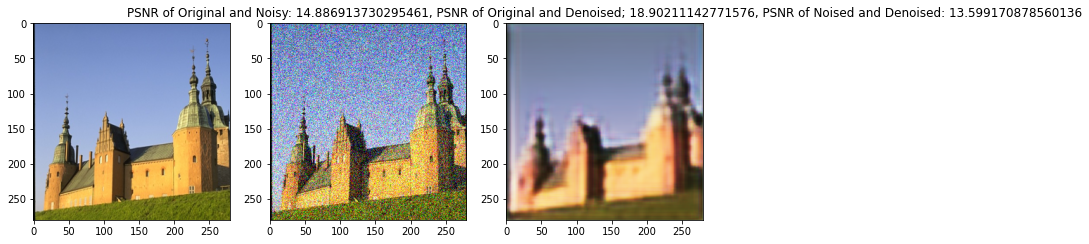

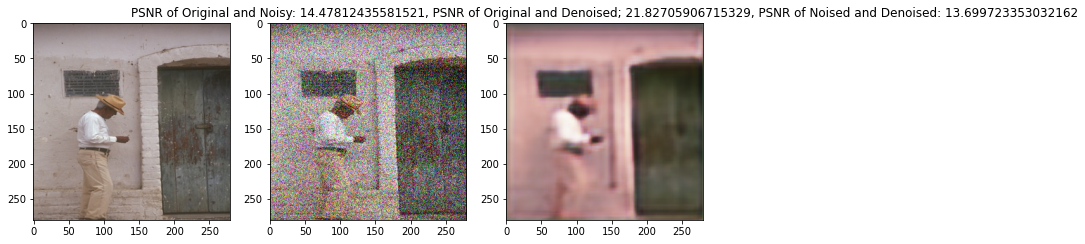

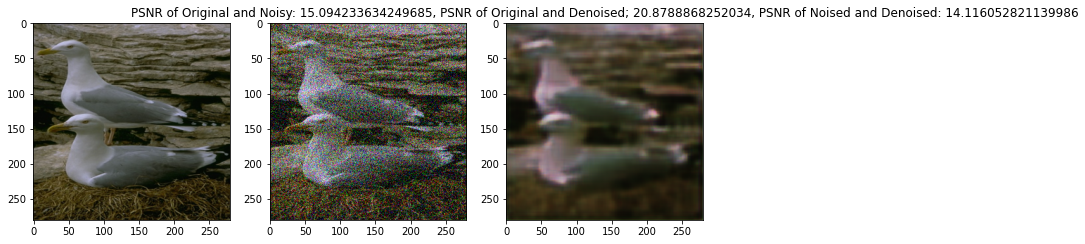

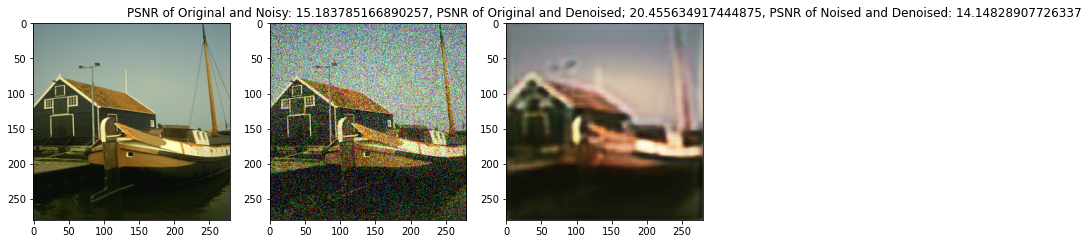

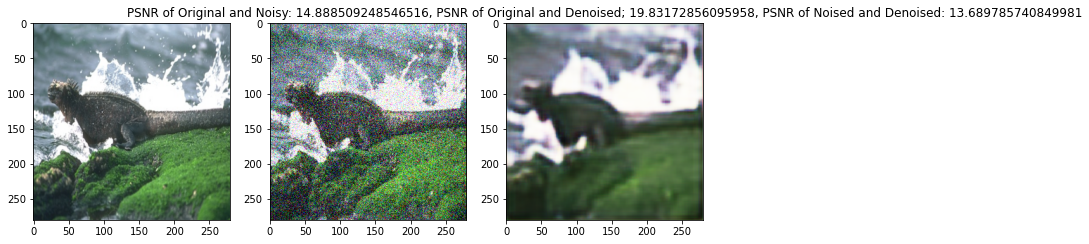

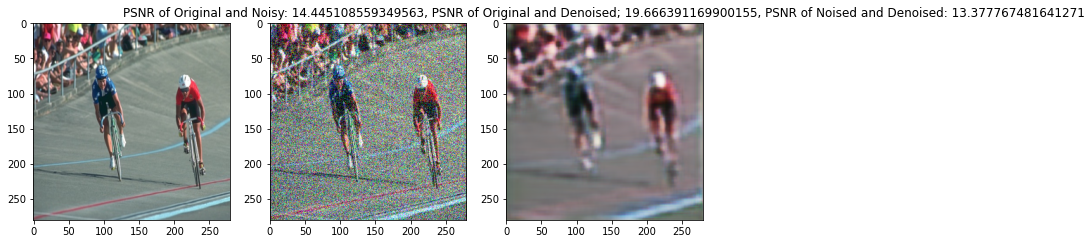

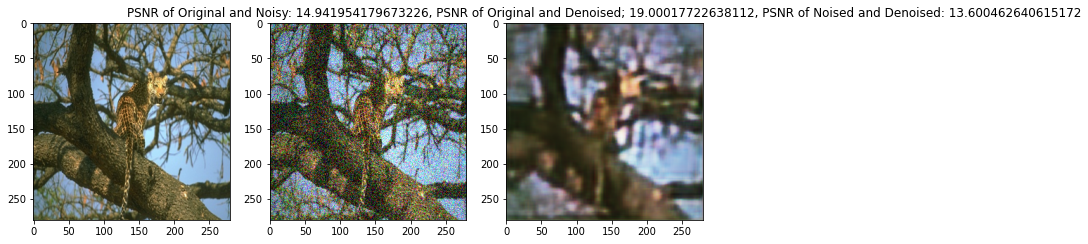

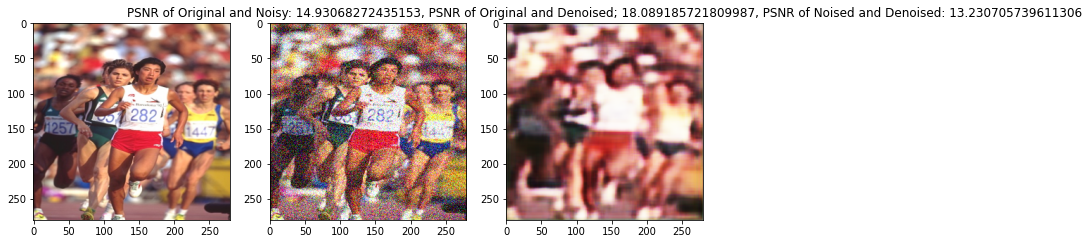

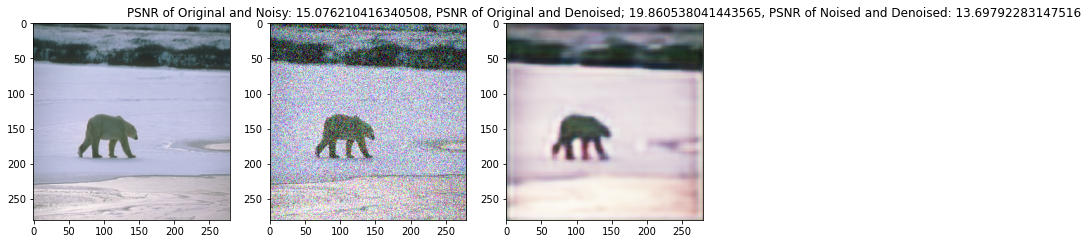

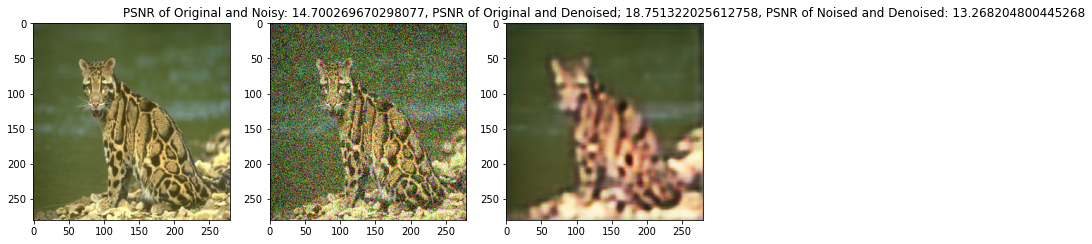

In [17]:
idxs = np.random.randint(0, 200, 10)
for img in zip(test_data[idxs], noisy_test_data[idxs], predicted[idxs]):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,12))
  plt.title(f'PSNR of Original and Noisy: {PSNR(img[0],img[1])}, PSNR of Original and Denoised; {PSNR(img[0],img[2])}, PSNR of Noised and Denoised: {PSNR(img[1],img[2])}')
  ax1.imshow(img[0])
  ax2.imshow(img[1])
  ax3.imshow(img[2])
  plt.show()